In [47]:
import sys
sys.path.append('..')

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit

import scipy.integrate

from functions_load_stf import *
from functions_end_stf import find_end_stf


In [49]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [50]:
window = 2

In [51]:
# Define a sum of Gaussian functions
def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    #print('params', params)
    for i in range(0, len(params), 3):
        #print(params[i:i+3])
        amp = params[i]
        mean = params[i+1]
        stddev = params[i+2]
        y += amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    return y

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [52]:
def plot_gaussians(popt, ax, time, momentrate, r_squared):
    if np.array_equal(popt, [0, 0, 0]):
        ax.plot(time, momentrate*1e18,
                    label='Data',
                    linestyle='-',
                    color='black',
                    zorder = 1)
        return
    num_gaussians = len(popt) // 3
    params = []
    for i in range(num_gaussians):
        if i < 10:
            ls = '--'
        else:
            ls = ':'
        amp = popt[0 + i*3]
        mean = popt[1 + i*3]
        stddev = popt[2 + i*3]
        params.append((amp, mean, stddev))
        x = time
        y = amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
        ax.plot(time, y*1e18,
                        #label=f'Gaussian {i+1}',
                        linestyle=ls,
                        zorder = 10)

    ax.plot(time, momentrate*1e18,
                        label='Data',
                        linestyle='-',
                        color='black')
    ax.plot(time, multi_gaussian(time, *popt)*1e18,
                            label=fr'Sum of {num_gaussians} Gaussians, $R^2$ = {r_squared:.3f}',
                            linestyle='-',
                            zorder = 1,
                            color='red')
    ax.legend()
    return

In [53]:
def get_data_and_prepare(row, dataset, get_stf):
	times_to_return = []
	momentrates_to_return = []

	if dataset == 'scardec_moy' or dataset == 'scardec_opt':
		name = row[dataset[:-4]]
	else:
		name = row[dataset]

	if name == '0' or name == 0:
		return None, None

	if dataset == 'scardec_moy':
		momentrate, time = get_stf(name, 'fctmoy')
	elif dataset == 'scardec_opt':
		momentrate, time = get_stf(name, 'fctopt')
	else:
		momentrate, time = get_stf(name)

	if dataset != 'sigloch':
		momentrate_list = [momentrate]
		time_list = [time]
	else:
		momentrate_list = momentrate
		time_list = time
		
	count = 0
	for momentrate, time in zip(momentrate_list, time_list):
		if time[0] == time[1]:
			time = time[1:]

		if dataset != 'sigloch':
			save_key = row.event
			dataset_name = dataset
		else:
			dataset_name = dataset + '_' + str(count)
			save_key = row.event + '_' + str(count)

		# if save_key in to_ignore:
		# 	continue
		#print(time[0:10])
		
		momentrate = np.array(momentrate)

		time = np.array(time)


		detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
		time = time[detected_start:detected_end] # shift to start STF at zero
		time = time - time[0]
		momentrate = momentrate[detected_start:detected_end]
		# max_len = max(max_len, len(momentrate))
		norm_momentrate = momentrate #/ max(momentrate)
		norm_time = time #/ max(time)
		#axs[0].plot(norm_time, norm_momentrate)

		interp_momentrate_stf = np.interp(np.linspace(0, max(time), int(max(time)*100)), norm_time, norm_momentrate)
		#interp_momentrate = np.zeros(20000)
		#if max(time) < 200:
		#	interp_momentrate[0:int(max(time)*100)] = interp_momentrate_stf
		#else:
		#	interp_momentrate = interp_momentrate_stf[0:20000]
		#interp_momentrate[interp_momentrate < 0] = 0
		
	times_to_return.append(np.linspace(0, max(time), int(max(time)*100)))
	momentrates_to_return.append(interp_momentrate_stf)
	return times_to_return, momentrates_to_return

In [54]:
def fit_gaussians(gaussian_num, time, momentrate):
	initial_guess = []
	for i in range(gaussian_num):
		initial_guess.extend([1, (max(time)/(gaussian_num+1)) * (i+1), 1])

	bounds = ([0 if i % 3 == 0 else -np.inf for i in range(len(initial_guess))],
			[np.inf for _ in range(len(initial_guess))])
	try:
		popt, pcov = curve_fit(multi_gaussian,
						time,
						momentrate,
						p0=initial_guess,
						bounds=bounds,
						maxfev=5000)
		y_fit = multi_gaussian(time, *popt)
		residuals = momentrate - y_fit
		ss_res = np.sum(residuals**2)
		ss_tot = np.sum((momentrate - np.mean(momentrate))**2)
		r_squared = 1 - (ss_res / ss_tot)
		
	except RuntimeError:
		r_squared = 0
		popt = [0, 0, 0]
		print('Optimal parameters not found')
	return r_squared, popt

In [ ]:
def gaussians_plot_overall(popt_list, r_squared_list, time, momentrate, event, r2_limit, dataset, max_mr = 0):
	if len(popt_list) == 1:
		fig, axs = plt.subplots(1,1, figsize=(10, 10), sharex=True)
		for i in range(0, len(popt_list)):
			popt = popt_list[i]
			plot_gaussians(popt, axs, time, momentrate, r_squared_list[0])
	elif len(popt_list) < 6:
		# print('in elif')
		fig, axs = plt.subplots(len(popt_list),1, figsize=(10, 10), sharex=True)
		for j in range(0, len(popt_list)):
			popt = popt_list[j]
			plot_gaussians(popt, axs[j], time, momentrate, r_squared_list[j])
	else:
		# print(len(popt_list))
		# print(event)
		if len(popt_list) % 2 == 0:
			#print('in if')
			fig, axs = plt.subplots(((len(popt_list) + 1) // 2) + 1, 1, figsize=(10, 10), sharex=True)
		else:
			#print('in else')
			fig, axs = plt.subplots(((len(popt_list)) // 2) + 1, 1, figsize=(10, 10), sharex=True)
		for j in range(0, len(popt_list), 2):
			popt = popt_list[j]
			plot_gaussians(popt, axs[j//2], time, momentrate, r_squared_list[j])
		# Plot the last element in popt_list
		if len(popt_list) % 2 == 0:
			popt = popt_list[-1]
			plot_gaussians(popt, axs[-1], time, momentrate, r_squared_list[j])


	if r_squared_list[-1] < r2_limit:
		plt.suptitle(f'{dataset} -- {event} - R-squared < {r2_limit}')
	else:
		plt.suptitle(f'{dataset} -- {event}')



	# Add a shared y-axis label by adding a subplot
	fig.add_subplot(111, frame_on=False)
	plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
	plt.xlabel("Time (s)")
	plt.ylabel("Moment Rate (x10^18 Nm/s)")
	plt.tight_layout()
	plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks_all/R2_{r2_limit*10:02}/{event}/{dataset}.png')
	# if len(popt_list) > 4:
	#plt.show()
	plt.close()

In [56]:
a = {'event1':{'a':1, 'b':2}, 'event2':[{'a':5, 'b':6}, {'a':7, 'b':8}]}

In [57]:
a

{'event1': {'a': 1, 'b': 2}, 'event2': [{'a': 5, 'b': 6}, {'a': 7, 'b': 8}]}

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 192 193 194 195 196 197 198 199 200 201 202 203 204]
17
1
0.6787274645782422
[1117.28815134  116.95798602   25.65973284]
2
0.8759226084239545
[ 0.18806135 10.15116866  5.51961433  0.8179456  17.73938494  1.55655841]
3
0.8846602302612288
[ 0.16579571  4.06998135  0.96628881  0.26412215  9.30253782  1.76123721
  0.83791525 17.60733481  1.99563072]
4
0.8908451151123424
[ 0.15269958  4.16461965  1.33124586  0.24039436  7.93345241  0.59665854
  0.29102767 10.01703513  0.88075461  0.82739542 17.6098624   2.07411219]
5
0.9457096028704914
[ 0.15222805  4.16501036  1.34123799  0.22229142  7.88279262  0.56844943
  0.28131519 10.00019026  1.01698585  0.38330776 14.01833054  0.43604694
  0.90640851 17.

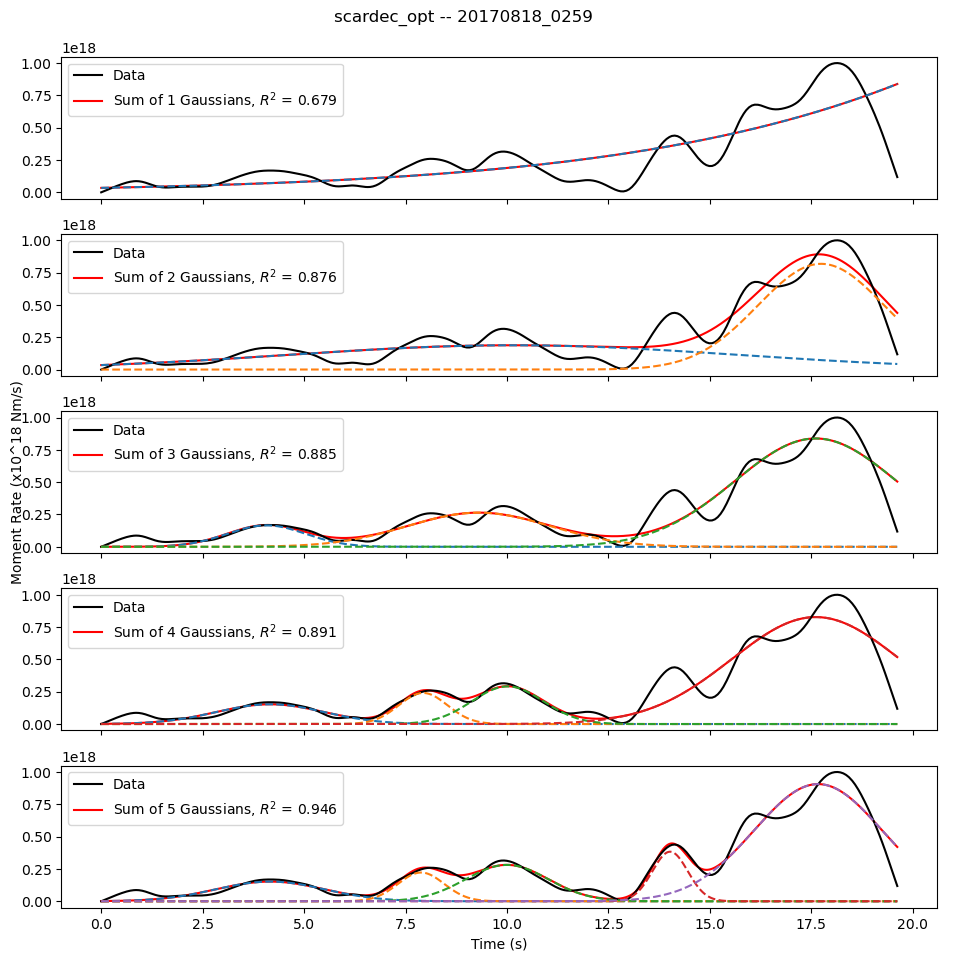

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341]
1
1
-0.44184092149627485
[ 0.42650401 10.39432358  1.27056243]
2
0.968382553555408
[ 0.43079445 10.3787532   1.23914949  0.98175719 18.47439848  1.76835607]


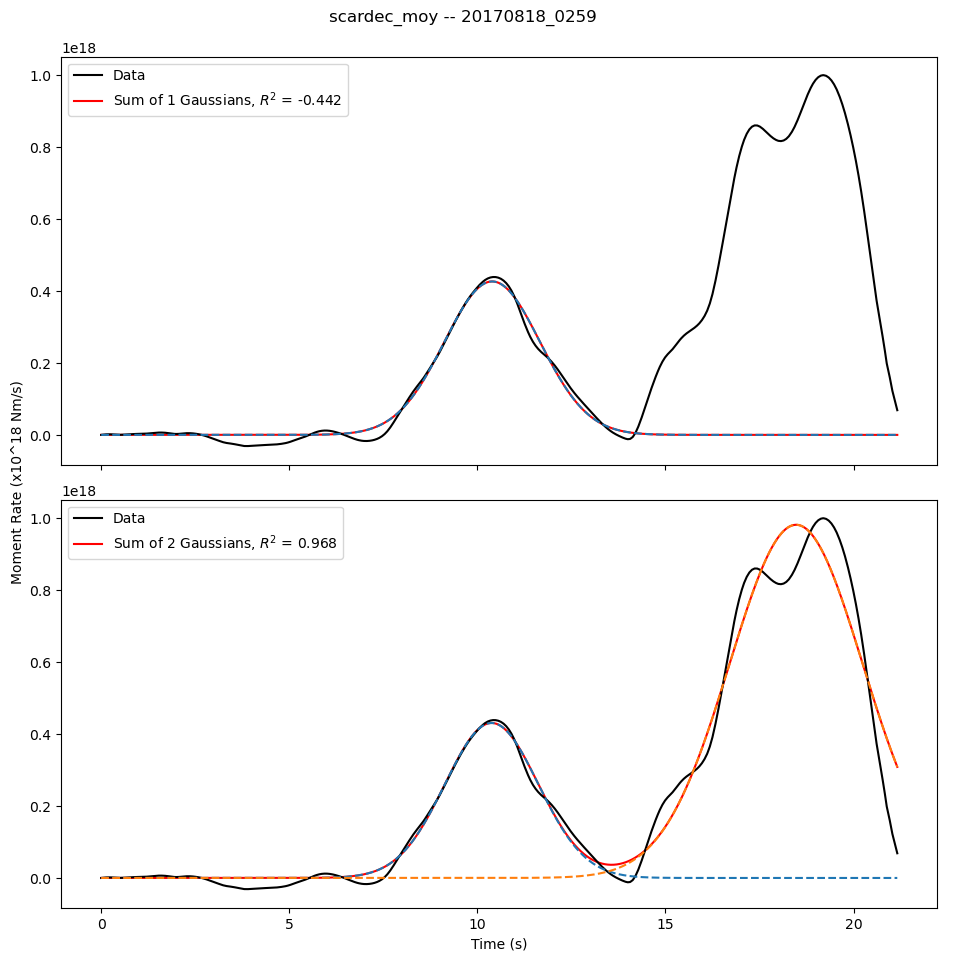

{'scardec_opt_r2': 0.9457096028704914, 'scardec_opt_num_gaussians': 5, 'scardec_moy_r2': 0.968382553555408, 'scardec_moy_num_gaussians': 2}
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43 179]
17
1
0.8722471672269617
[0.817555   7.56786018 2.97203778]
2
0.9726635988383777
[0.55852561 5.0856756  1.86953041 0.84047516 8.8027231  1.38090746]


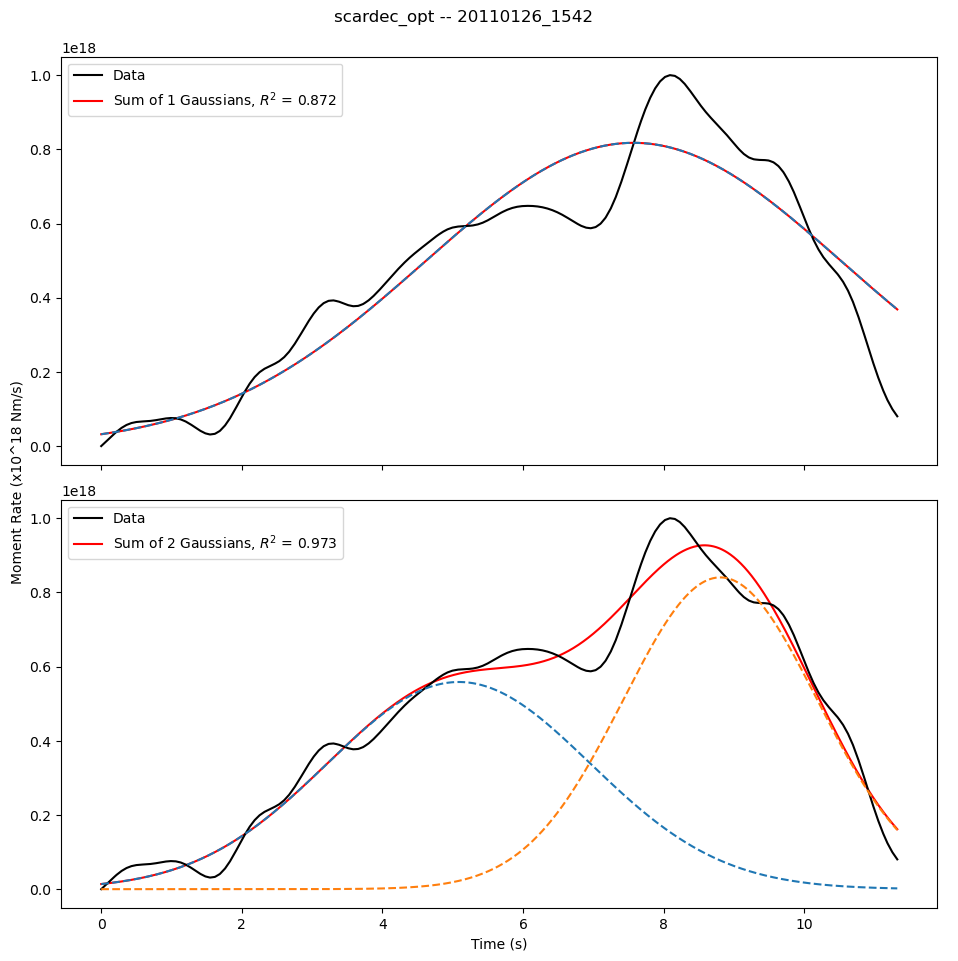

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236]
1
1
0.9170192812863537
[0.89717783 8.87932862 2.83607203]


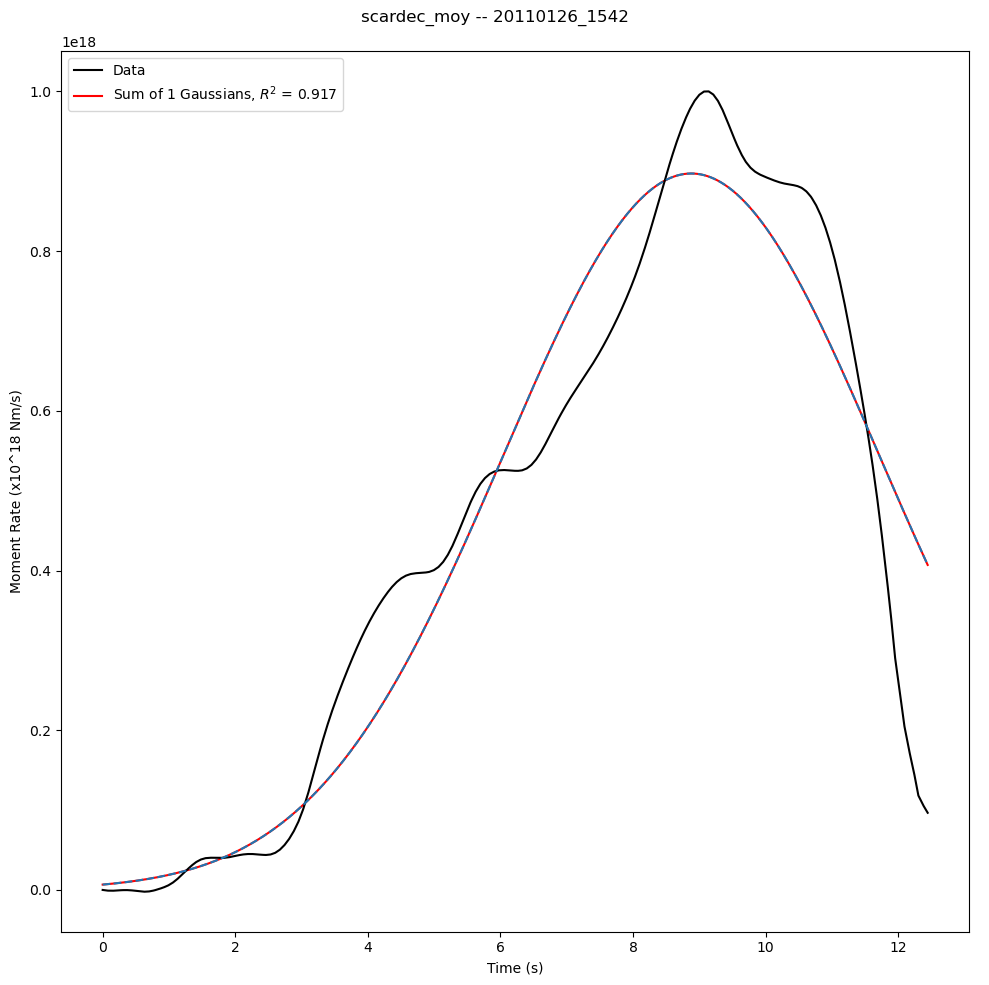

[]
0
1
0.910127709401475
[0.93833641 2.61620223 0.65155182]


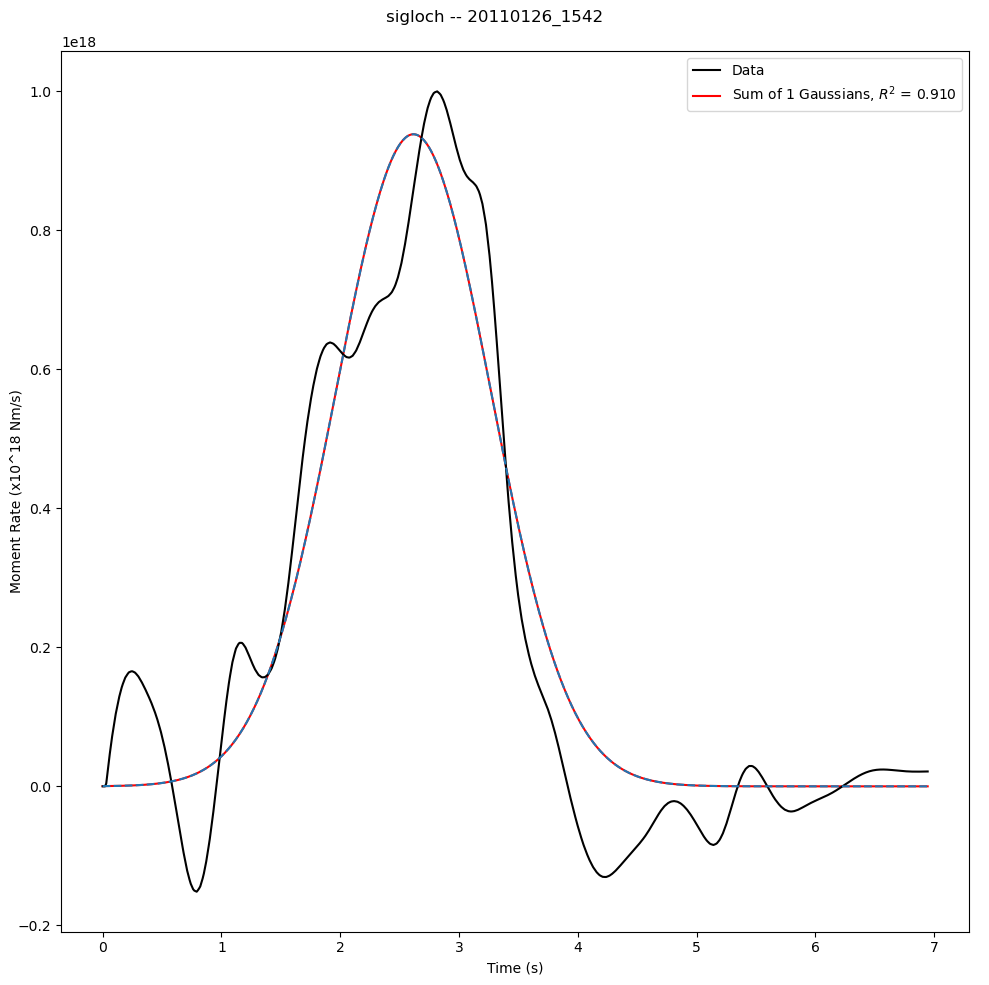

{'scardec_opt_r2': 0.9726635988383777, 'scardec_opt_num_gaussians': 2, 'scardec_moy_r2': 0.9170192812863537, 'scardec_moy_num_gaussians': 1, 'sigloch_1_r2': 0.910127709401475, 'sigloch_1_num_gaussians': 1}
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
17
1
0.8876624589460202
[0.95778583 2.00962725 1.26858901]
2
0.9928764305177623
[0.81153668 1.35098657 0.67853219 0.64413337 2.91759982 0.9471519 ]


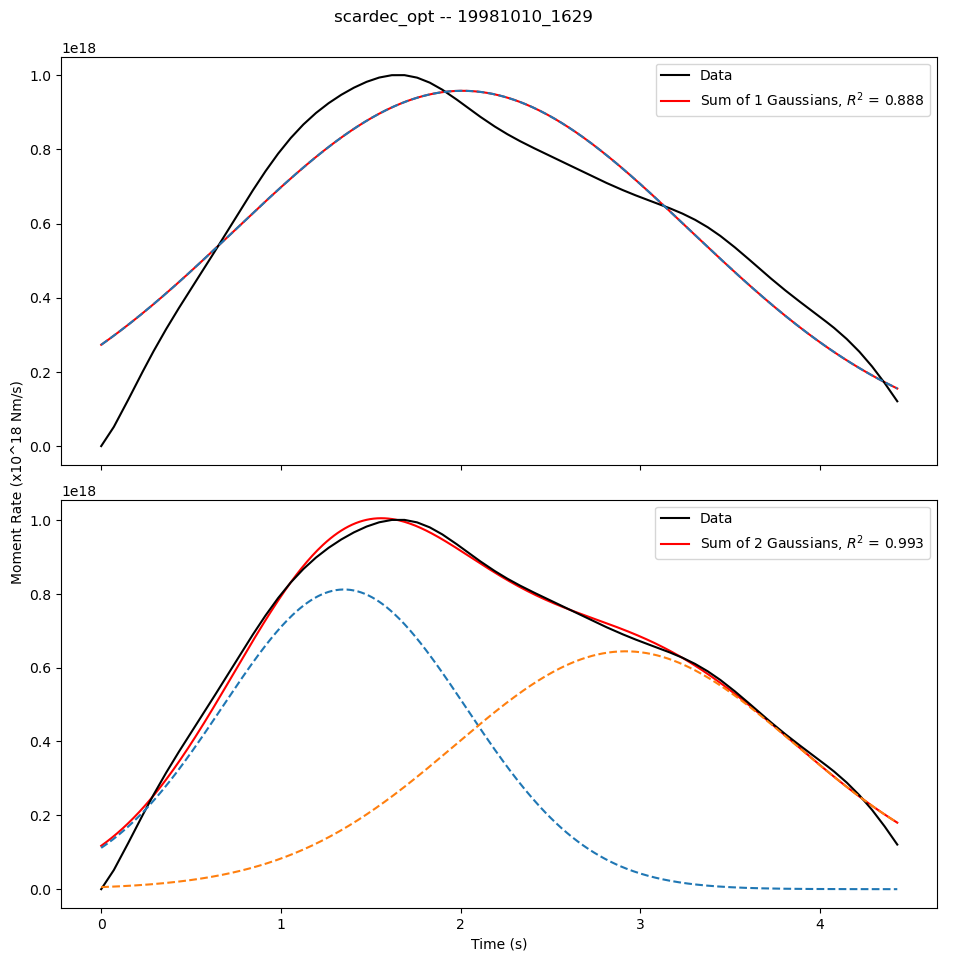

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178]
13
1
0.9138988341287252
[0.98016119 2.3039596  1.19680734]


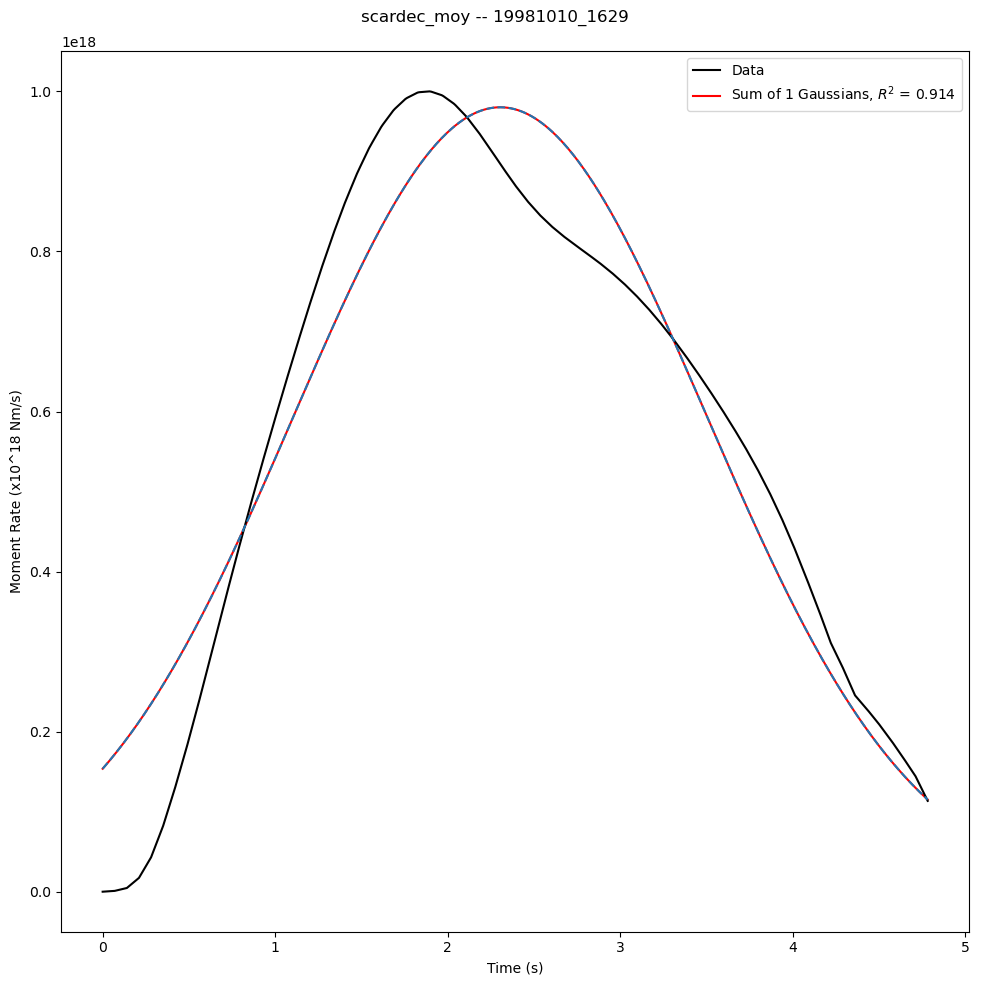

{'scardec_opt_r2': 0.9928764305177623, 'scardec_opt_num_gaussians': 2, 'scardec_moy_r2': 0.9138988341287252, 'scardec_moy_num_gaussians': 1}
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 35 36 37 38
 39]
17
1
0.9254701136966295
[0.94548334 4.15489733 1.20271489]


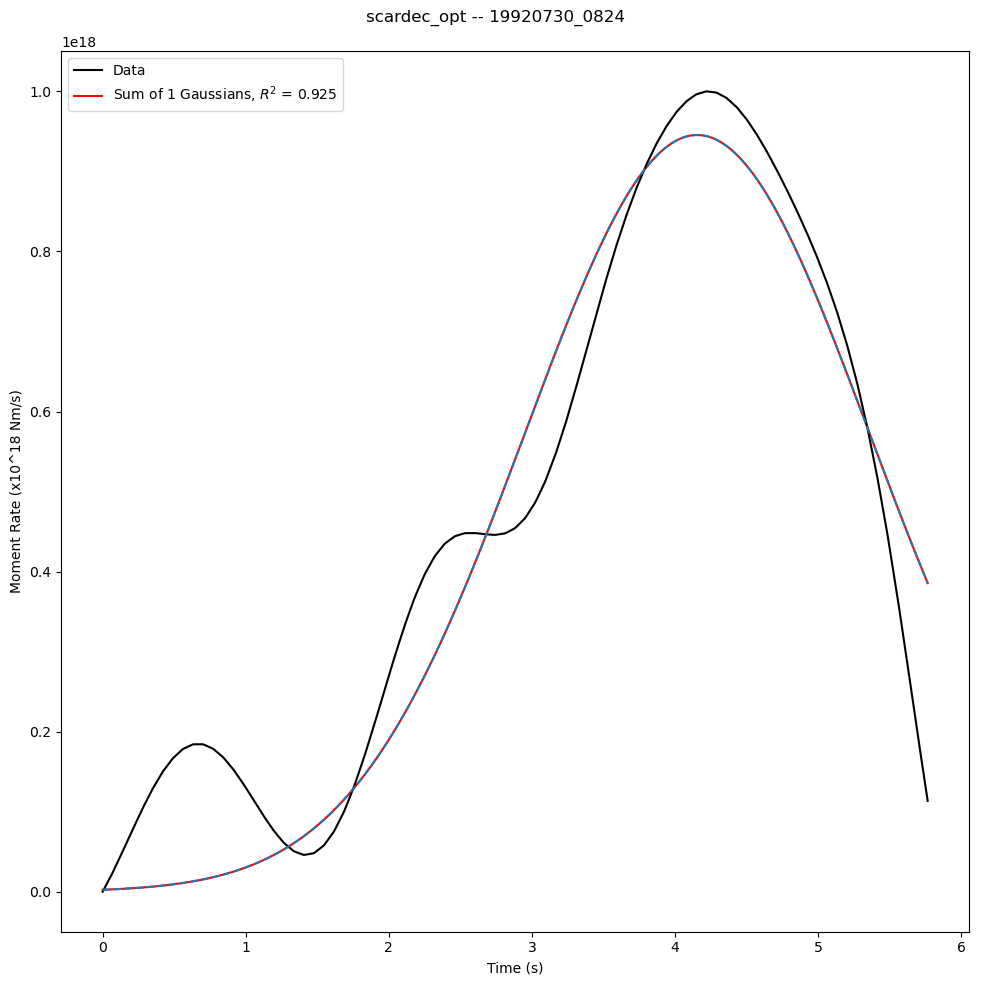

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39 101 102 103 104 105]
1
1
0.9820882233865199
[0.95725214 5.17066069 1.18095876]


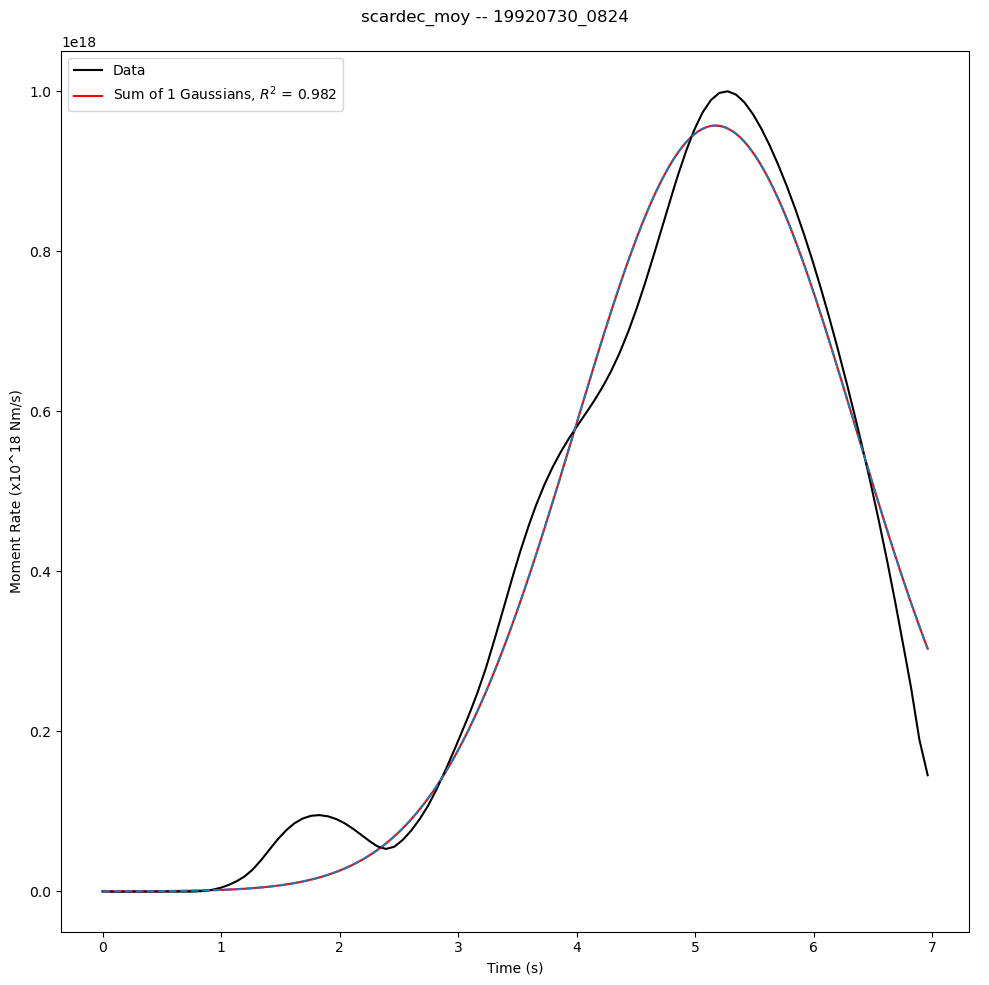

{'scardec_opt_r2': 0.9254701136966295, 'scardec_opt_num_gaussians': 1, 'scardec_moy_r2': 0.9820882233865199, 'scardec_moy_num_gaussians': 1}
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26 151 152 153 154 155 156 157 158 159]
17
1
0.22876225971060749
[ 0.50756163 14.23069897  9.73116477]
2
0.4013220195020931
[ 0.490079    6.5031014   3.02569351  0.63731    15.78259113  2.92031348]
3
0.42342201586838646
[ 0.22027664  5.01109841  0.37434809  0.44937301  6.85116916  3.27599152
  0.63353283 15.89045305  2.80439506]
4
0.6197959315573893
[ 0.41713243  5.02425646  2.21268246  0.64426165  8.10489615  0.57090996
  0.31791673 11.17563221  0.48288635  0.65046504 15.71418301  2.89460905]
5
0.6401859079705147
[ 0.41469596  5.0823616   2.30283064  0.64356471  8.12497534  0.57939192
  0.41698079 11.26751204  0.61740417  0.26534873 13.52268671  0.48393192
  0.63880876 16.1744868   2.47633506]
6
0.7308858047461366
[ 0.31550332  1.85024195  0

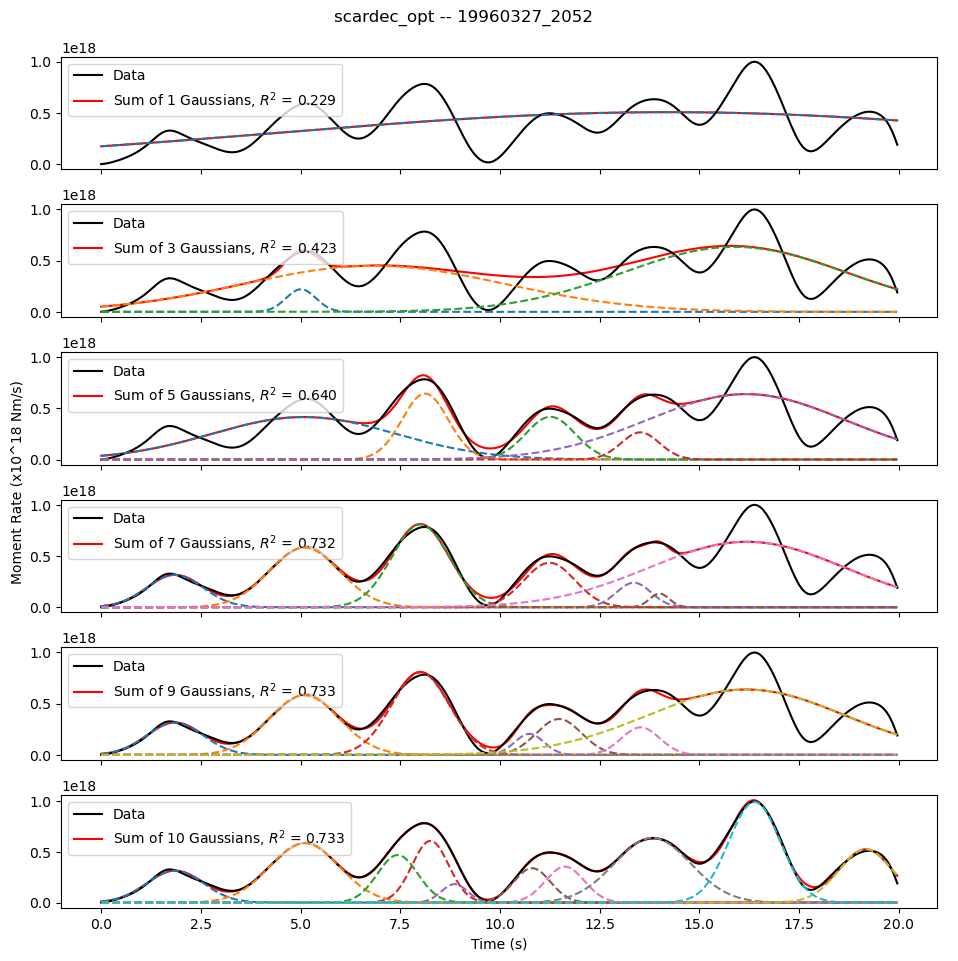

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 296 297 298 299 300 301]
1
1
0.26382687893659185
[ 0.60533179 13.07564051  7.43168072]
2
0.670389819333599
[ 0.69323887  7.56831692  2.4559995   0.88681439 16.0919882   2.1315046 ]
3
0.8314289807460935
[ 0.53770619  6.2072958   2.01608939  0.8487142   8.9851226   0.59508326
  0.86799145 15.90696984  2.34754629]
4
0.8902636201852996
[ 0.53813851  6.21197686  2.01532068  0.85554178  9.00001893  0.60841594
  0.47608923 12.4427462   0.44804876  0.9035661  16.20613955  1.99626692]
5
0.9142289354460515
[ 0.26199368  3.1885608   1.10364588  0.66857662  6.26515651  0.90539783
  1.05035385  8.88411677  0.68942045  0.78399597 15.34785826  2.20168667
  0.47547986 17.73920924  0.58144026]


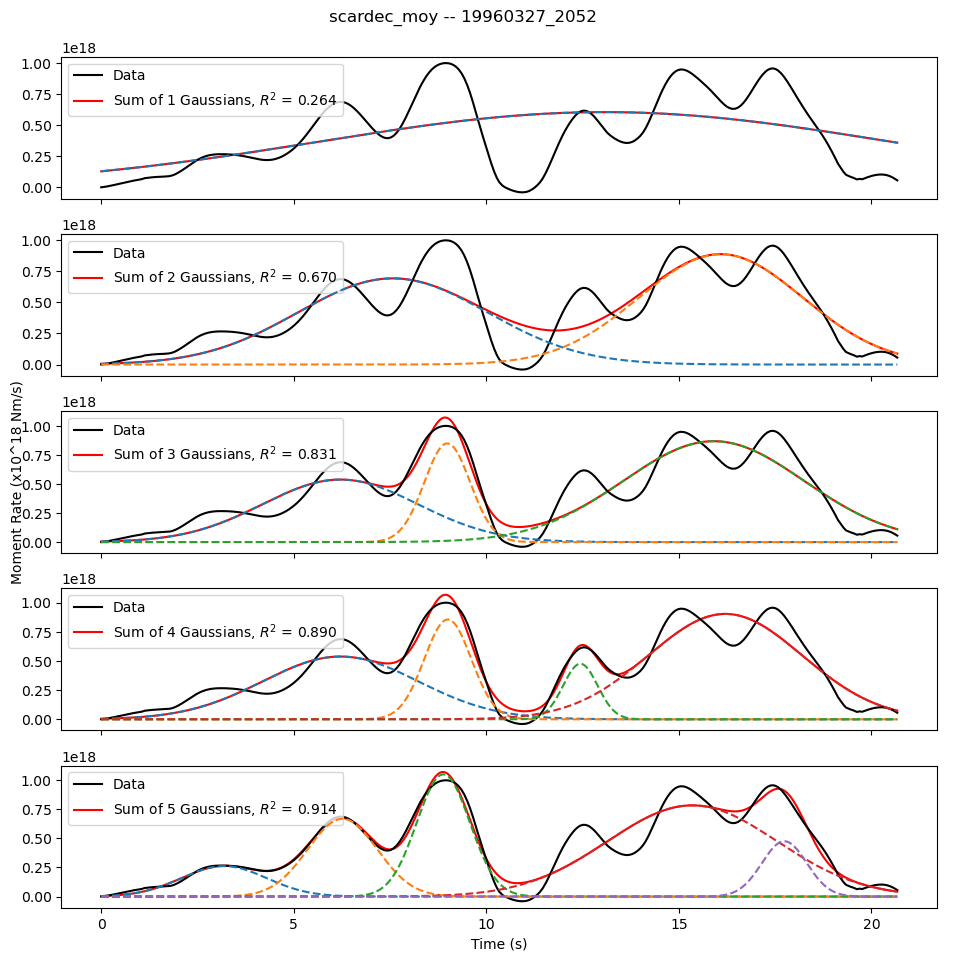

{'scardec_opt_r2': 0.9970585790529974, 'scardec_opt_num_gaussians': 10, 'scardec_moy_r2': 0.9142289354460515, 'scardec_moy_num_gaussians': 5}


In [ ]:
smoothing_points = 1
r2_limit = 0.9

output_dir = f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks_all/R2_{r2_limit*10:02}/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

gaussians_dict = {}
for i, row in combined.iterrows():
	if i >= 5:
		break
	if not os.path.exists(output_dir+f'{row.event}/'):
		os.makedirs(output_dir+f'{row.event}/')
	with open(f"/home/earthquakes1/homes/Rebecca/phd/stf/figures/large_scale_peaks_all/R2_{r2_limit*10:02}/{row.event}/fits.txt", "w") as file:
		event_dict = {}
		file.write(f"Processing {row.event}\n")	
		for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):
			times_to_use, momentrates_to_use = get_data_and_prepare(row, dataset, get_stf)
			if times_to_use is None:
				continue
			sigloch_count = 0
			for time, momentrate in zip(times_to_use, momentrates_to_use):
				if dataset == 'sigloch':
					sigloch_count += 1
					file.write(f'Processing {dataset}_{sigloch_count}\n')
					name_to_save = f'{dataset}_{sigloch_count}'
				else:
					file.write(f'Processing {dataset}\n')
					name_to_save = dataset
				momentrate = momentrate - momentrate[0]
				max_mr = max(momentrate)
				momentrate = momentrate / max_mr
				popt_list = []
				r_squared_list = []
				total_moment = scipy.integrate.simpson(momentrate, dx = time[1]-time[0])
				for gaussian_num in range(1, 11):
					#print(gaussian_num)
					file.write(f'Fitting {gaussian_num} Gaussians\n')
					r_squared, popt = fit_gaussians(gaussian_num, time, momentrate)
					r_squared_list.append(r_squared)
					popt_list.append(popt)
					#print(r_squared)
					#print(popt)

					num_gaussians = len(popt) // 3
					params = []
					for i in range(num_gaussians):
						amp = popt[i*3]
						mean = popt[i*3 + 1]
						stddev = popt[i*3 + 2]
						params.append((amp, mean, stddev))
						x = time
						y = amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
						file.write(f"Gaussian {i+1} - Amplitude: {amp}, Mean: {mean}, Standard Deviation: {stddev}\n")
					file.write(f'R-squared: {r_squared}\n')

					moment_gaussian = scipy.integrate.simpson(multi_gaussian(time, *popt), dx = time[1]-time[0])
					file.write(f'Proportion moment from Gaussian fit: {moment_gaussian/total_moment}\n')
					if r_squared > r2_limit:
						break

				event_dict[name_to_save + '_r2'] = r_squared_list[-1]
				event_dict[name_to_save + '_num_gaussians'] = len(popt)//3

				if r_squared_list[-1] < r2_limit:
					#print(row.event, f'r2 < {r2_limit}')
					file.write(f'!!!!!!!!!!!! R-squared < {r2_limit} !!!!!!!!!!!!!!!!!!!!\n')
					#print(popt_list)

				gaussians_plot_overall(popt_list, r_squared_list, time, momentrate, row.event, r2_limit, dataset, max_mr)
			sigloch_count += 1
	print(event_dict)
	gaussians_dict[row.event] = event_dict


In [67]:
gaussians_dict

{'20170818_0259': {'scardec_opt_r2': 0.9457096028704914,
  'scardec_opt_num_gaussians': 5,
  'scardec_moy_r2': 0.968382553555408,
  'scardec_moy_num_gaussians': 2},
 '20110126_1542': {'scardec_opt_r2': 0.9726635988383777,
  'scardec_opt_num_gaussians': 2,
  'scardec_moy_r2': 0.9170192812863537,
  'scardec_moy_num_gaussians': 1,
  'sigloch_1_r2': 0.910127709401475,
  'sigloch_1_num_gaussians': 1},
 '19981010_1629': {'scardec_opt_r2': 0.9928764305177623,
  'scardec_opt_num_gaussians': 2,
  'scardec_moy_r2': 0.9138988341287252,
  'scardec_moy_num_gaussians': 1},
 '19920730_0824': {'scardec_opt_r2': 0.9254701136966295,
  'scardec_opt_num_gaussians': 1,
  'scardec_moy_r2': 0.9820882233865199,
  'scardec_moy_num_gaussians': 1},
 '19960327_2052': {'scardec_opt_r2': 0.9970585790529974,
  'scardec_opt_num_gaussians': 10,
  'scardec_moy_r2': 0.9142289354460515,
  'scardec_moy_num_gaussians': 5}}